딥러닝 응용 3주차 과제
==
## 3-2 LSTM Classification

## Import Libraries
학습에 필요한 라이브러리들을 불러온다

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

## Load Data
사용할 데이터: abalone.csv

In [2]:
# Load Data
df = pd.read_csv('abalone.csv')
df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Data Preprocessing

1. 'Sex', 'Rings' 특징을 LabelEncoder를 사용해 Categorical Data로 변환
2. Sample 개수가 20개 미만인 Class는 삭제
3. Target='Rings' 구성
4. 클래스 불균형을 해결하기 위해 SMOTE Oversampling 진행
5. SplitSequence 진행 (같은 클래스에 대한 샘플들로 하나의 시퀀스를 구성)

SMOTE란, 소수 클래스의 샘플을 합성하여 데이터셋을 균형있게 만드는 방법
출처: https://jaylala.tistory.com/entry/불균형데이터처리-오버샘플링Oversampling-SMOTE



In [11]:
# Label Encoding for categorical variables
sex_encoder = LabelEncoder()
rings_encoder = LabelEncoder()

# Remove small classes
min_count_threshold = 20
class_counts = df['Rings'].value_counts()
classes_to_keep = class_counts[class_counts > min_count_threshold].index
df_filtered = df[df['Rings'].isin(classes_to_keep)]

new_class_distribution = df_filtered['Rings'].value_counts().sort_index()

# Encode the 'Sex' and 'Rings' columns using .loc to avoid warnings
df_filtered.loc[:, 'Sex'] = sex_encoder.fit_transform(df_filtered['Sex'])
df_filtered.loc[:, 'Rings'] = rings_encoder.fit_transform(df_filtered['Rings'])
df_filtered = df_filtered.drop(['id'], axis=1)

# Create Target
x = df_filtered.drop(['Rings'], axis=1)
y = df_filtered['Rings']

# Oversampling
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

x_resampled_df = pd.DataFrame(x_resampled, columns=x.columns)
x_resampled_df['Sex'] = x_resampled_df['Sex'].astype(int)

def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()

    df = pd.DataFrame(X)
    df['Rings'] = y

    grouped = df.groupby('Rings')

    for class_value, group in grouped:
        if len(group) >= n_steps + 1:
            sampled_group = group.sample(n=min(600, len(group)), random_state=42)
            sampled_group = sampled_group.sort_index()
            sampled_array = sampled_group.values

            # Create sequences from the sampled data
            for i in range(len(sampled_array) - n_steps):
                seq_x = sampled_array[i:i+n_steps, :-1].astype(np.float32)
                seq_y = sampled_array[i+n_steps, -1]
                X_seq.append(seq_x)
                y_seq.append(seq_y)

    X_seq, y_seq = shuffle(X_seq, y_seq, random_state=42)
    return np.array(X_seq), np.array(y_seq)

# Create sequence
n_steps = 20
x_seq, y_seq = split_sequence(x_resampled_df.values, y_resampled, n_steps)
# x_seq = x_seq.reshape((x_seq.shape[0], 1, n_steps, -1))

## Plot Data Distribution

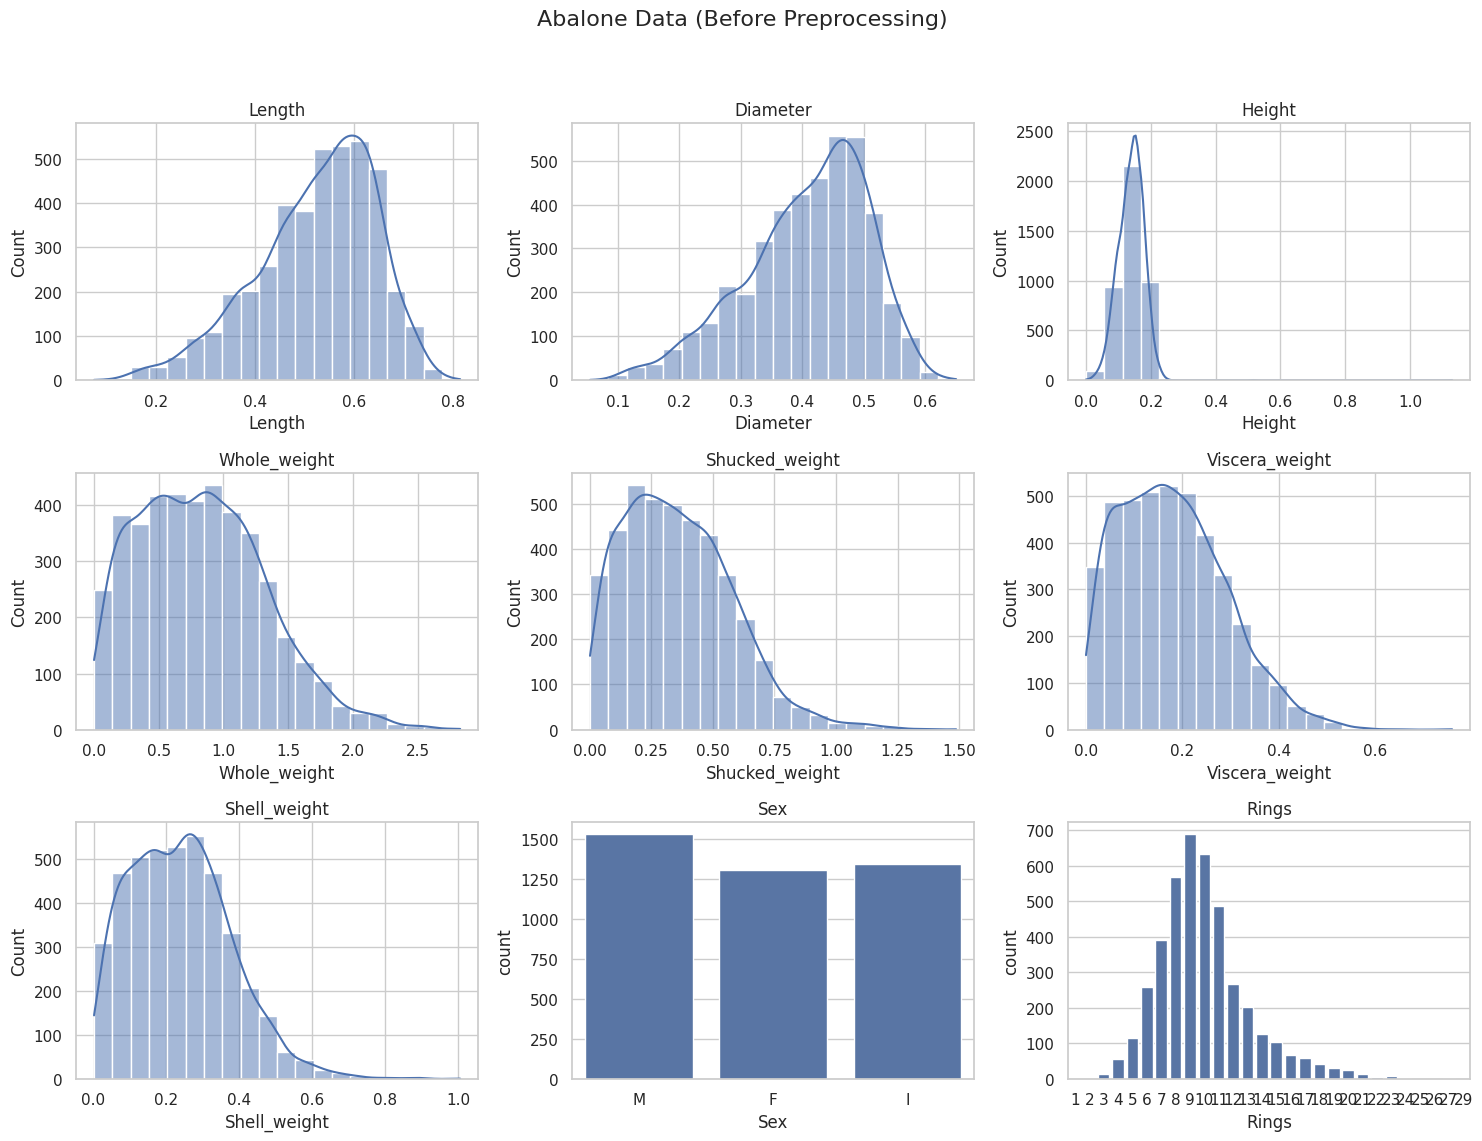

In [4]:
sns.set(style="whitegrid")

continuous_columns = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
categorical_columns = ['Sex', 'Rings']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Abalone Data (Before Preprocessing)', fontsize=16)

for idx, col in enumerate(continuous_columns):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[idx // 3, idx % 3], color="b")
    axes[idx // 3, idx % 3].set_title(f'{col}')

for idx, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[(idx + len(continuous_columns)) // 3, (idx + len(continuous_columns)) % 3], color="b")
    axes[(idx + len(continuous_columns)) // 3, (idx + len(continuous_columns)) % 3].set_title(f'{col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

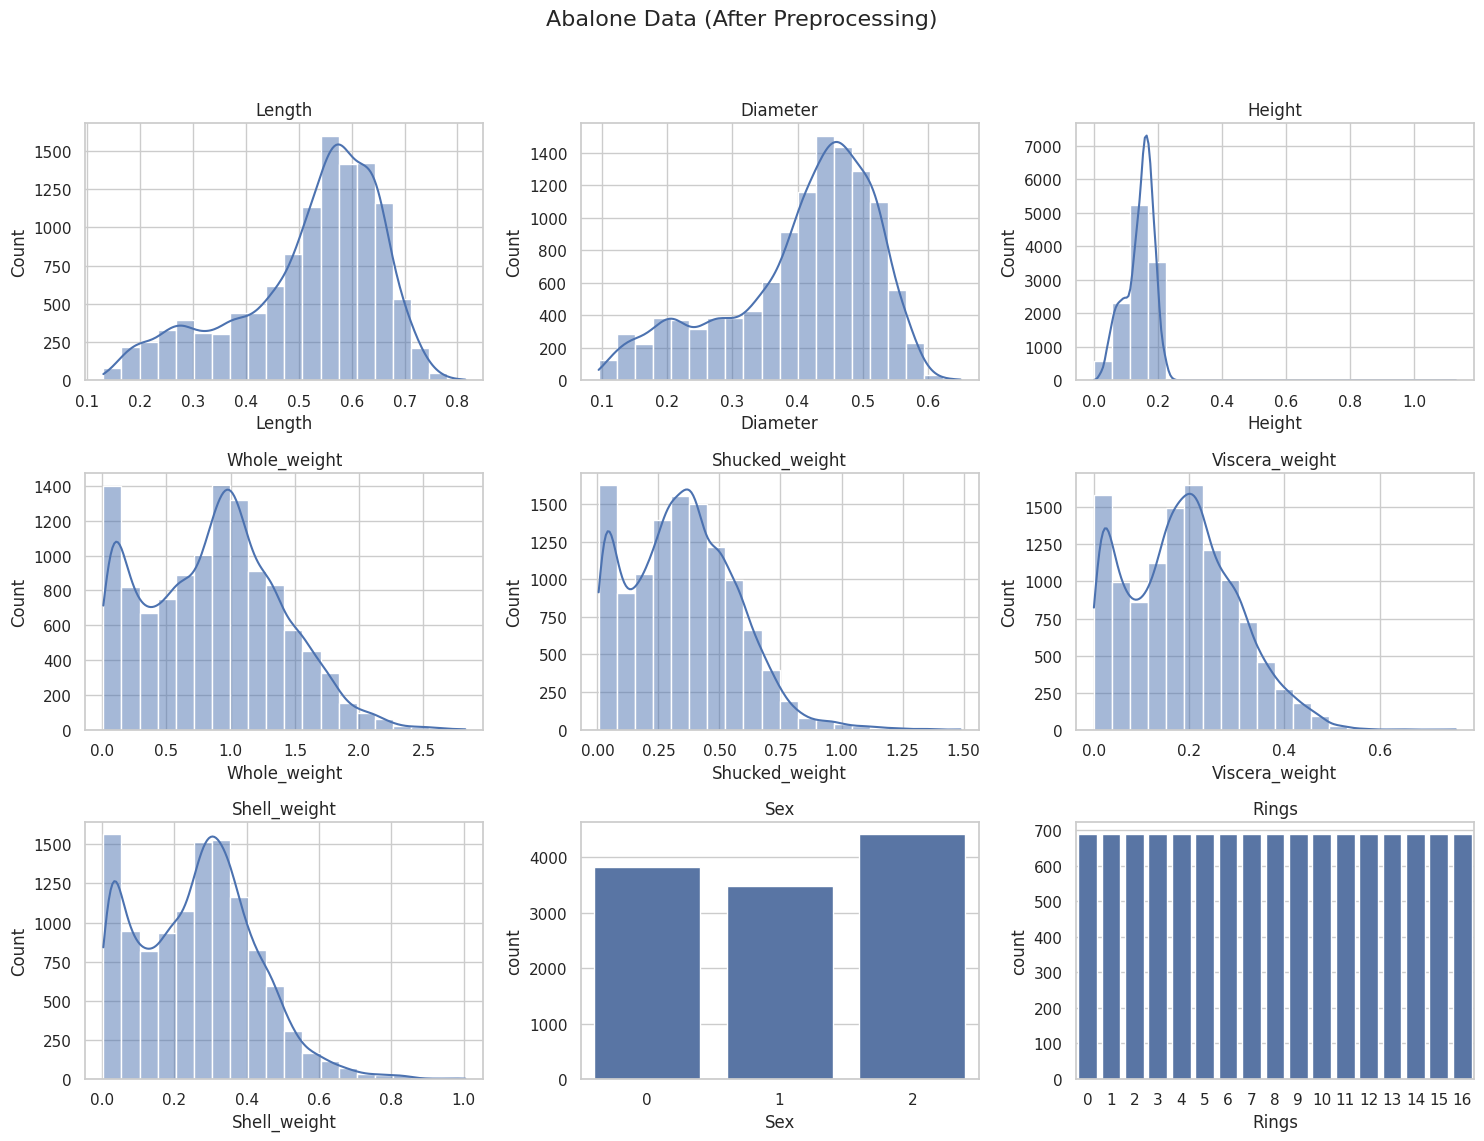

In [5]:
sns.set(style="whitegrid")

continuous_columns = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
categorical_columns = ['Sex']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Abalone Data (After Preprocessing)', fontsize=16)

for idx, col in enumerate(continuous_columns):
    sns.histplot(x_resampled_df[col], bins=20, kde=True, ax=axes[idx // 3, idx % 3], color="b")
    axes[idx // 3, idx % 3].set_title(f'{col}')

sns.countplot(x='Sex', data=x_resampled_df, ax=axes[2, 1], color="b")
axes[2, 1].set_title('Sex')


sns.countplot(x=y_resampled, color="b")
plt.title('Rings')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Dataset Load
Train-Test Split은 진행한 후 CNN에 맞는 크기로 구성을 함

In [12]:
# Train-Test Split
x_train_seq, x_test_seq, y_train_seq, y_test_seq = train_test_split(x_seq, y_seq, test_size=0.2, stratify=y_seq)

# Convert to PyTorch Tensors
x_train_tensor = torch.tensor(x_train_seq, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long)

# Dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## LSTM Class

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_output):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_output)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        return x

In [19]:
# Hyperparameters
input_size = x_seq.shape[2]
hidden_size = 64
num_layers = 4
n_output = len(torch.unique(y_train_tensor))

# Functions
model = LSTMNet(input_size, hidden_size, num_layers, n_output).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
print(model)

LSTMNet(
  (lstm): LSTM(8, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=17, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Train Network
- batch_size=128
- epoch=100
- learning_rate = 1e-3

In [21]:
# Train Function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test Function
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Store predictions and true labels for later analysis
            all_preds.append(pred.argmax(1).cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, test_loss / len(dataloader), correct / len(dataloader.dataset)


# Train + Test Loop
epochs = 200
for t in range(epochs):
    print(f"Epoch [{t+1}/{epochs}] ---------------------------")
    train(train_loader, model, loss_fn, optimizer)
    y_pred, y_true, avg_loss, accuracy = test(test_loader, model, loss_fn)
    print(f"Test Accuracy: {100 * accuracy:.2f}%, Avg loss: {avg_loss:.6f}")

Epoch [1/200] ---------------------------
Test Accuracy: 11.76%, Avg loss: 2.404931
Epoch [2/200] ---------------------------
Test Accuracy: 18.56%, Avg loss: 2.215186
Epoch [3/200] ---------------------------
Test Accuracy: 27.13%, Avg loss: 2.005408
Epoch [4/200] ---------------------------
Test Accuracy: 28.80%, Avg loss: 1.997739
Epoch [5/200] ---------------------------
Test Accuracy: 40.21%, Avg loss: 1.744070
Epoch [6/200] ---------------------------
Test Accuracy: 45.33%, Avg loss: 1.468319
Epoch [7/200] ---------------------------
Test Accuracy: 42.90%, Avg loss: 1.448607
Epoch [8/200] ---------------------------
Test Accuracy: 51.37%, Avg loss: 1.288187
Epoch [9/200] ---------------------------
Test Accuracy: 44.83%, Avg loss: 1.373681
Epoch [10/200] ---------------------------
Test Accuracy: 48.23%, Avg loss: 1.274381
Epoch [11/200] ---------------------------
Test Accuracy: 50.66%, Avg loss: 1.244996
Epoch [12/200] ---------------------------
Test Accuracy: 52.08%, Avg loss

CNN Classification Report
              precision    recall  f1-score   support

           4       1.00      1.00      1.00       116
           5       1.00      1.00      1.00       116
           6       1.00      0.95      0.97       116
           7       0.95      1.00      0.97       116
           8       0.98      0.99      0.99       116
           9       0.97      0.97      0.97       116
          10       0.97      0.96      0.97       116
          11       0.98      0.99      0.99       116
          12       0.99      0.97      0.98       116
          13       0.98      1.00      0.99       116
          14       1.00      0.99      1.00       116
          15       0.98      0.99      0.99       116
          16       1.00      0.99      1.00       116
          17       1.00      0.99      1.00       116
          18       0.99      1.00      1.00       116
          19       1.00      1.00      1.00       116
          20       0.99      1.00      1.00       116



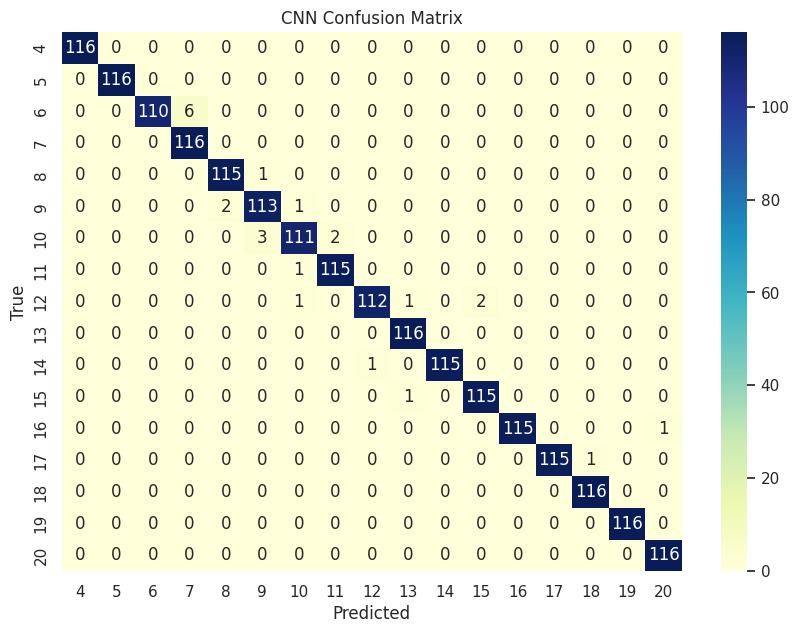

In [22]:
# Inverse Encoding
y_true_original = rings_encoder.inverse_transform(y_true)
y_pred_original = rings_encoder.inverse_transform(y_pred)

# Classification Report and Confusion Matrix
print("CNN Classification Report")
print(classification_report(y_true_original, y_pred_original, zero_division=0))

cm_original = confusion_matrix(y_true_original, y_pred_original)
unique_labels_original = sorted(set(y_true_original) | set(y_pred_original))

plt.figure(figsize=(10, 7))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=unique_labels_original, yticklabels=unique_labels_original)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()